In [4]:
import scanpy as sc
import numpy as np
import phate
import seaborn as sns
from ae_model import Autoencoder
from scvi.distributions import ZeroInflatedNegativeBinomial
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from datasets import GeodesicDataset

In [5]:
# adata = sc.read_h5ad('data/parse_pbmc_embeddings_cellflow.h5ad')
# adata = sc.read_h5ad('data/k562.h5ad')

PERTURB_COL = 'cytokine'

In [6]:
# # get subset of cells ot memory
# rng = np.random.default_rng(seed=42)
# adata = adata[(adata.obs["cell_type"] == 'CD14 Mono')] # & ((adata.obs["donor"] == "Donor1") | (adata.obs["donor"] == "Donor3"))]
# idx = rng.choice(adata.n_obs, size=20000, replace=False)
# adata_sample = adata[idx, :].to_memory()

In [7]:
# # save to h5ad
# adata_sample.write_h5ad('data/pmbc_c14_mono_all_donors_20k_subset.h5ad')

adata_sample = sc.read_h5ad('data/pmbc_c14_mono_all_donors_20k_subset.h5ad')

# adata_sample = sc.read_h5ad('data/jiang24_processed_20k_subset.h5ad')

# adata_sample = sc.read_h5ad('data/k562_20k_subset.h5ad')

In [8]:
adata_sample

AnnData object with n_obs × n_vars = 20000 × 2000
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'donor', 'cytokine', 'treatment', 'cell_type', 'cytokine_family'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'donor_embeddings', 'esm2_embeddings', 'hvg', 'log1p'

In [9]:
adata_sample.layers["counts"] = adata_sample.X.copy()
sc.pp.normalize_total(adata_sample, target_sum=1e4)
if 'log1p' in adata_sample.uns:
    del adata_sample.uns['log1p']
sc.pp.log1p(adata_sample)
sc.tl.pca(adata_sample, svd_solver='arpack')
sc.pp.neighbors(adata_sample)
sc.tl.umap(adata_sample)

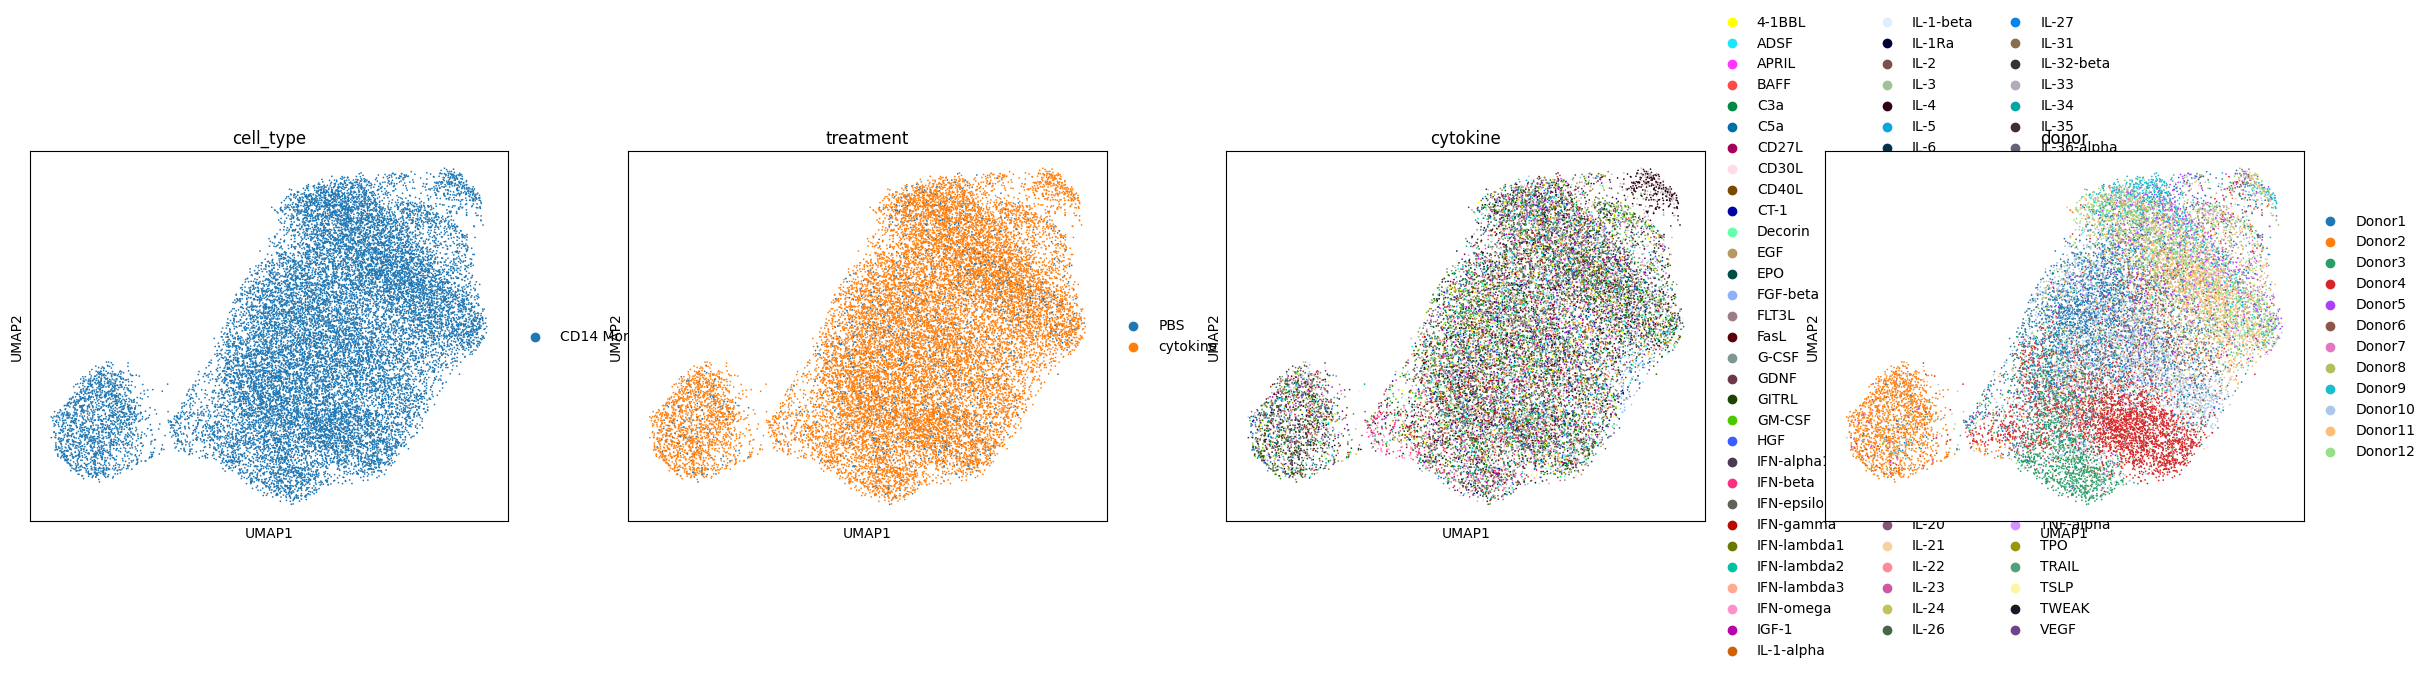

In [10]:
sc.pl.umap(adata_sample, color=["cell_type", "treatment", "cytokine", "donor"])

In [8]:
phate_operator = phate.PHATE(knn=5, decay=15, n_jobs=-2, verbose=True)
adata_sample.obsm['X_phate'] = phate_operator.fit_transform(adata_sample.X)

Calculating PHATE...
  Running PHATE on 20000 observations and 2000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.06 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.35 seconds.
    Calculating affinities...
    Calculated affinities in 3.29 seconds.
  Calculated graph and diffusion operator in 5.04 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 8.06 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.70 seconds.
  Calculated landmark operator in 9.77 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 0.76 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.23 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.41 seconds.
Calculated PHATE in 21.03 seconds.


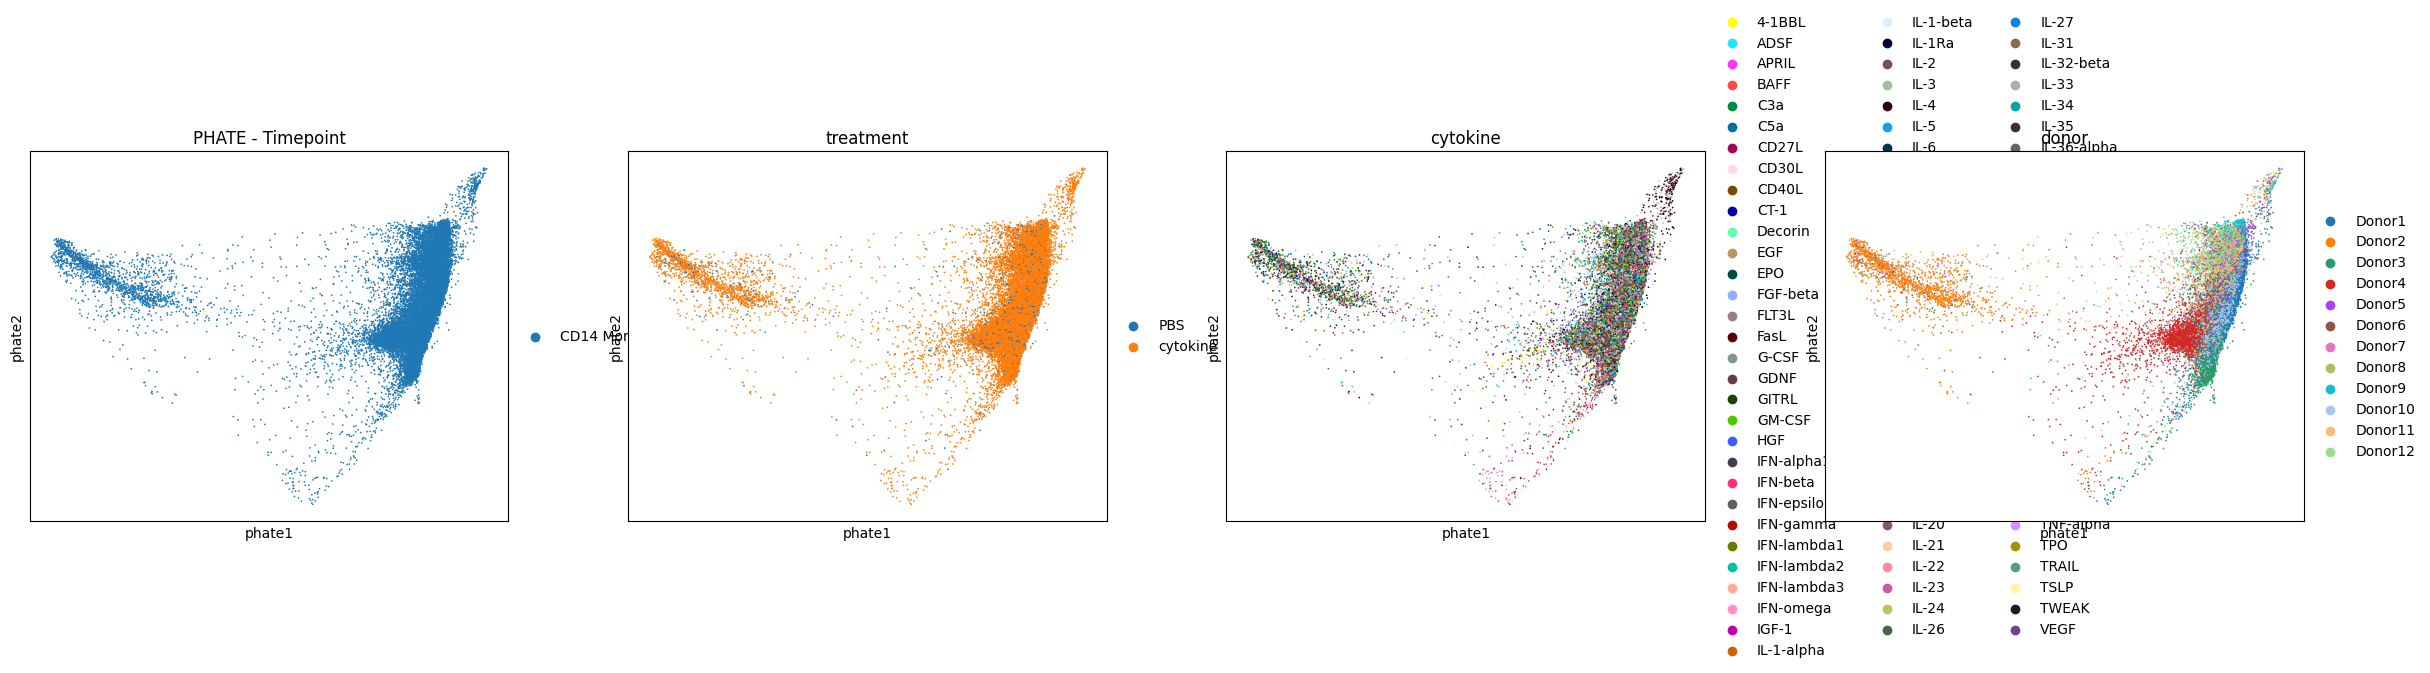

In [9]:
sc.pl.embedding(adata_sample, basis='phate', color=['cell_type', 'treatment', 'cytokine', 'donor'], cmap="Spectral",title='PHATE - Timepoint')

In [10]:
# for cell_type in adata_sample.obs['cell_type'].unique():
#     adata_sample_cell_specific = adata_sample[adata_sample.obs["cell_type"] == cell_type].copy()
#     phate_operator = phate.PHATE(knn=5, decay=15, n_jobs=-2, verbose=True)
#     adata_sample_cell_specific.obsm['X_phate'] = phate_operator.fit_transform(adata_sample_cell_specific.X)
#     sc.pl.embedding(adata_sample_cell_specific, basis='phate', color=['pathway', 'control'], cmap="Spectral", title=f'PHATE - {cell_type} - Pathway')

## Train AE

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics.pairwise import pairwise_distances
from typing import List, Union, Optional, Tuple
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def build_phate_collate(dataset):
    def collate(batch):
        batch_x = torch.stack([item['x'] for item in batch])
        batch_raw = torch.stack([item['raw'] for item in batch])
        batch_indices = torch.tensor([item['index'] for item in batch], device=dataset.device)
        distance_vec = dataset.distance_vector(batch_indices)
        mask_vec = dataset.mask_vector(batch_indices)
        return {
            'x': batch_x,
            'raw': batch_raw,
            'd': distance_vec,
            'mask': mask_vec,
            'indices': batch_indices,
        }

    return collate

In [13]:
adata_sample.obsm['X_phate'].shape

(20000, 2)

In [14]:
A = kneighbors_graph(adata_sample.X, n_neighbors=15, mode='distance', include_self=False)
geodesic_dist_matrix = shortest_path(A, directed=False)
max_dist = geodesic_dist_matrix[np.isfinite(geodesic_dist_matrix)].max()
geodesic_dist_matrix[~np.isfinite(geodesic_dist_matrix)] = max_dist * 2.0

In [16]:
cell_type_codes = adata_sample.obs['cell_type'].astype('category').cat.codes.values

geodesic_dataset = GeodesicDataset(
    X=adata_sample.X.toarray().astype(np.float32), # log1p expression
    distance_matrix=geodesic_dist_matrix,
    raw=adata_sample.layers["counts"].toarray().astype(np.float32), # raw
    # cell_types=cell_type_codes,
    device=device
)

geo_collate = build_phate_collate(geodesic_dataset)

In [17]:
input_dim = adata_sample.X.shape[1]
latent_dim = 32
hidden_dim = 256

In [37]:
# Training hyperparameters
batch_size=4096
num_epochs = 500
learning_rate = 1e-3
recon_weight = 0.01
phate_weight = 0 # 0.1  # Higher weight since we have fewer parameters

model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim)

print("Model architecture:")
print(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
distance_criterion = torch.nn.MSELoss()

model.to(device)

train_dataset, test_dataset = random_split(
    geodesic_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=geo_collate,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=geo_collate,
)

history = {
    'recon_loss': [],
    'recon_loss_weighted': [],
    'phate_loss': [],
    'phate_loss_weighted': [],
    'train_loss': []
}

for epoch in tqdm(range(num_epochs), desc='Epochs'):

    # print(epoch)

    model.train()

    recon_loss_epoch = 0.0
    phate_loss_epoch = 0.0
    n_seen_epoch = 0

    for batch in train_loader:

        # print(batch)

        x_log = batch['x']
        x_raw = batch['raw']
        mask = batch['mask']

        phate_distances = batch['d']

        optimizer.zero_grad()

        library_size = x_raw.sum(dim=1, keepdim=True)
        mean_proportions, dispersion, dropout, latent_reps = model(x_log)
        mean_counts = mean_proportions * library_size

        # compute reconstruction loss
        dist = ZeroInflatedNegativeBinomial(
            mu=mean_counts, 
            theta=dispersion, 
            zi_logits=dropout,
        )
        recon_loss = -dist.log_prob(x_raw).sum()

        # compute pariwise phate distances in latent representation
        latent_pairwise_distance_matrix = torch.cdist(latent_reps, latent_reps)
        upper_triangle_indices = torch.triu_indices(latent_pairwise_distance_matrix.shape[0], latent_pairwise_distance_matrix.shape[1], offset=1)
        latent_pairwise_distance_vector = latent_pairwise_distance_matrix[upper_triangle_indices[0], upper_triangle_indices[1]] # get upper triangle to match phate distances
        # print(f"latent_pairwise_distance_vector: {latent_pairwise_distance_vector.shape}")

        if mask.sum() > 0:
            phate_loss = distance_criterion(phate_distances[mask], latent_pairwise_distance_vector[mask])
        else:
            phate_loss = torch.tensor(0.0, device=device, requires_grad=True)

        loss = (recon_loss * recon_weight) + (phate_loss * phate_weight)

        # backprop and update params
        loss.backward()
        optimizer.step()

        current_batch_size = x_raw.size(0)
        n_seen_epoch += current_batch_size
        recon_loss_epoch += recon_loss.item() # already sum
        phate_loss_epoch += phate_loss.item() * current_batch_size

    avg_recon_loss = recon_loss_epoch / n_seen_epoch
    avg_phate_loss = phate_loss_epoch / n_seen_epoch
    total_loss = avg_recon_loss * recon_weight + avg_phate_loss * phate_weight

    history["recon_loss"].append(avg_recon_loss)
    history["recon_loss_weighted"].append(avg_recon_loss * recon_weight)
    history["phate_loss"].append(avg_phate_loss)
    history["phate_loss_weighted"].append(avg_phate_loss * phate_weight)
    history["train_loss"].append(total_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Recon Loss Weighted: {avg_recon_loss * recon_weight:.4f}, PHATE Loss Weighted: {avg_phate_loss * phate_weight:.4f}")

Model architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2000, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (z_layer): Linear(in_features=256, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder_mean): Sequential(
    (0): Linear(in_features=256, out_features=2000, bias=True)
    (1): Softmax(dim=-1)
  )
  (decoder_dropout): Linear(in_features=256, out_features=2000, bias=True)
)


Epochs:   2%|▏         | 10/500 [00:04<03:11,  2.56it/s]

Epoch [10/500], Loss: 6.6930, Recon Loss Weighted: 6.6930, PHATE Loss Weighted: 0.0000


Epochs:   4%|▍         | 20/500 [00:08<03:34,  2.24it/s]

Epoch [20/500], Loss: 6.4633, Recon Loss Weighted: 6.4633, PHATE Loss Weighted: 0.0000


Epochs:   6%|▌         | 30/500 [00:12<03:07,  2.50it/s]

Epoch [30/500], Loss: 6.3464, Recon Loss Weighted: 6.3464, PHATE Loss Weighted: 0.0000


Epochs:   8%|▊         | 40/500 [00:17<03:24,  2.25it/s]

Epoch [40/500], Loss: 6.2575, Recon Loss Weighted: 6.2575, PHATE Loss Weighted: 0.0000


Epochs:  10%|█         | 50/500 [00:21<02:59,  2.50it/s]

Epoch [50/500], Loss: 6.1857, Recon Loss Weighted: 6.1857, PHATE Loss Weighted: 0.0000


Epochs:  12%|█▏        | 60/500 [00:25<02:53,  2.53it/s]

Epoch [60/500], Loss: 6.1278, Recon Loss Weighted: 6.1278, PHATE Loss Weighted: 0.0000


Epochs:  14%|█▍        | 70/500 [00:29<03:06,  2.31it/s]

Epoch [70/500], Loss: 6.0814, Recon Loss Weighted: 6.0814, PHATE Loss Weighted: 0.0000


Epochs:  16%|█▌        | 80/500 [00:33<02:24,  2.90it/s]

Epoch [80/500], Loss: 6.0434, Recon Loss Weighted: 6.0434, PHATE Loss Weighted: 0.0000


Epochs:  18%|█▊        | 90/500 [00:37<02:36,  2.61it/s]

Epoch [90/500], Loss: 6.0109, Recon Loss Weighted: 6.0109, PHATE Loss Weighted: 0.0000


Epochs:  20%|██        | 100/500 [00:40<02:18,  2.88it/s]

Epoch [100/500], Loss: 5.9830, Recon Loss Weighted: 5.9830, PHATE Loss Weighted: 0.0000


Epochs:  22%|██▏       | 110/500 [00:44<02:09,  3.01it/s]

Epoch [110/500], Loss: 5.9580, Recon Loss Weighted: 5.9580, PHATE Loss Weighted: 0.0000


Epochs:  24%|██▍       | 120/500 [00:47<02:15,  2.80it/s]

Epoch [120/500], Loss: 5.9354, Recon Loss Weighted: 5.9354, PHATE Loss Weighted: 0.0000


Epochs:  26%|██▌       | 130/500 [00:51<02:04,  2.98it/s]

Epoch [130/500], Loss: 5.9147, Recon Loss Weighted: 5.9147, PHATE Loss Weighted: 0.0000


Epochs:  28%|██▊       | 140/500 [00:55<02:11,  2.74it/s]

Epoch [140/500], Loss: 5.8961, Recon Loss Weighted: 5.8961, PHATE Loss Weighted: 0.0000


Epochs:  30%|███       | 150/500 [00:58<02:00,  2.91it/s]

Epoch [150/500], Loss: 5.8775, Recon Loss Weighted: 5.8775, PHATE Loss Weighted: 0.0000


Epochs:  32%|███▏      | 160/500 [01:02<02:12,  2.57it/s]

Epoch [160/500], Loss: 5.8606, Recon Loss Weighted: 5.8606, PHATE Loss Weighted: 0.0000


Epochs:  34%|███▍      | 170/500 [01:05<01:53,  2.91it/s]

Epoch [170/500], Loss: 5.8449, Recon Loss Weighted: 5.8449, PHATE Loss Weighted: 0.0000


Epochs:  36%|███▌      | 180/500 [01:09<02:11,  2.43it/s]

Epoch [180/500], Loss: 5.8292, Recon Loss Weighted: 5.8292, PHATE Loss Weighted: 0.0000


Epochs:  38%|███▊      | 190/500 [01:13<01:52,  2.75it/s]

Epoch [190/500], Loss: 5.8142, Recon Loss Weighted: 5.8142, PHATE Loss Weighted: 0.0000


Epochs:  40%|████      | 200/500 [01:16<01:41,  2.96it/s]

Epoch [200/500], Loss: 5.8004, Recon Loss Weighted: 5.8004, PHATE Loss Weighted: 0.0000


Epochs:  42%|████▏     | 210/500 [01:20<01:59,  2.43it/s]

Epoch [210/500], Loss: 5.7865, Recon Loss Weighted: 5.7865, PHATE Loss Weighted: 0.0000


Epochs:  44%|████▍     | 220/500 [01:24<01:49,  2.57it/s]

Epoch [220/500], Loss: 5.7742, Recon Loss Weighted: 5.7742, PHATE Loss Weighted: 0.0000


Epochs:  46%|████▌     | 230/500 [01:28<02:05,  2.15it/s]

Epoch [230/500], Loss: 5.7611, Recon Loss Weighted: 5.7611, PHATE Loss Weighted: 0.0000


Epochs:  48%|████▊     | 240/500 [01:33<01:46,  2.43it/s]

Epoch [240/500], Loss: 5.7493, Recon Loss Weighted: 5.7493, PHATE Loss Weighted: 0.0000


Epochs:  50%|█████     | 250/500 [01:37<01:56,  2.14it/s]

Epoch [250/500], Loss: 5.7374, Recon Loss Weighted: 5.7374, PHATE Loss Weighted: 0.0000


Epochs:  52%|█████▏    | 260/500 [01:41<01:38,  2.45it/s]

Epoch [260/500], Loss: 5.7250, Recon Loss Weighted: 5.7250, PHATE Loss Weighted: 0.0000


Epochs:  54%|█████▍    | 270/500 [01:45<01:29,  2.57it/s]

Epoch [270/500], Loss: 5.7148, Recon Loss Weighted: 5.7148, PHATE Loss Weighted: 0.0000


Epochs:  56%|█████▌    | 280/500 [01:49<01:40,  2.18it/s]

Epoch [280/500], Loss: 5.7029, Recon Loss Weighted: 5.7029, PHATE Loss Weighted: 0.0000


Epochs:  58%|█████▊    | 290/500 [01:54<01:23,  2.51it/s]

Epoch [290/500], Loss: 5.6923, Recon Loss Weighted: 5.6923, PHATE Loss Weighted: 0.0000


Epochs:  60%|██████    | 300/500 [01:58<01:25,  2.34it/s]

Epoch [300/500], Loss: 5.6819, Recon Loss Weighted: 5.6819, PHATE Loss Weighted: 0.0000


Epochs:  62%|██████▏   | 310/500 [02:02<01:15,  2.51it/s]

Epoch [310/500], Loss: 5.6726, Recon Loss Weighted: 5.6726, PHATE Loss Weighted: 0.0000


Epochs:  64%|██████▍   | 320/500 [02:06<01:10,  2.57it/s]

Epoch [320/500], Loss: 5.6632, Recon Loss Weighted: 5.6632, PHATE Loss Weighted: 0.0000


Epochs:  66%|██████▌   | 330/500 [02:10<01:09,  2.43it/s]

Epoch [330/500], Loss: 5.6531, Recon Loss Weighted: 5.6531, PHATE Loss Weighted: 0.0000


Epochs:  68%|██████▊   | 340/500 [02:14<01:02,  2.56it/s]

Epoch [340/500], Loss: 5.6439, Recon Loss Weighted: 5.6439, PHATE Loss Weighted: 0.0000


Epochs:  70%|███████   | 350/500 [02:19<01:02,  2.38it/s]

Epoch [350/500], Loss: 5.6350, Recon Loss Weighted: 5.6350, PHATE Loss Weighted: 0.0000


Epochs:  72%|███████▏  | 360/500 [02:23<00:57,  2.43it/s]

Epoch [360/500], Loss: 5.6258, Recon Loss Weighted: 5.6258, PHATE Loss Weighted: 0.0000


Epochs:  74%|███████▍  | 370/500 [02:27<00:58,  2.23it/s]

Epoch [370/500], Loss: 5.6179, Recon Loss Weighted: 5.6179, PHATE Loss Weighted: 0.0000


Epochs:  76%|███████▌  | 380/500 [02:31<00:46,  2.58it/s]

Epoch [380/500], Loss: 5.6084, Recon Loss Weighted: 5.6084, PHATE Loss Weighted: 0.0000


Epochs:  78%|███████▊  | 390/500 [02:35<00:51,  2.15it/s]

Epoch [390/500], Loss: 5.6011, Recon Loss Weighted: 5.6011, PHATE Loss Weighted: 0.0000


Epochs:  80%|████████  | 400/500 [02:39<00:41,  2.39it/s]

Epoch [400/500], Loss: 5.5942, Recon Loss Weighted: 5.5942, PHATE Loss Weighted: 0.0000


Epochs:  82%|████████▏ | 410/500 [02:43<00:35,  2.56it/s]

Epoch [410/500], Loss: 5.5844, Recon Loss Weighted: 5.5844, PHATE Loss Weighted: 0.0000


Epochs:  84%|████████▍ | 420/500 [02:48<00:33,  2.39it/s]

Epoch [420/500], Loss: 5.5777, Recon Loss Weighted: 5.5777, PHATE Loss Weighted: 0.0000


Epochs:  86%|████████▌ | 430/500 [02:52<00:27,  2.54it/s]

Epoch [430/500], Loss: 5.5705, Recon Loss Weighted: 5.5705, PHATE Loss Weighted: 0.0000


Epochs:  88%|████████▊ | 440/500 [02:56<00:28,  2.12it/s]

Epoch [440/500], Loss: 5.5626, Recon Loss Weighted: 5.5626, PHATE Loss Weighted: 0.0000


Epochs:  90%|█████████ | 450/500 [03:00<00:20,  2.38it/s]

Epoch [450/500], Loss: 5.5555, Recon Loss Weighted: 5.5555, PHATE Loss Weighted: 0.0000


Epochs:  92%|█████████▏| 460/500 [03:05<00:18,  2.19it/s]

Epoch [460/500], Loss: 5.5489, Recon Loss Weighted: 5.5489, PHATE Loss Weighted: 0.0000


Epochs:  94%|█████████▍| 470/500 [03:09<00:12,  2.48it/s]

Epoch [470/500], Loss: 5.5421, Recon Loss Weighted: 5.5421, PHATE Loss Weighted: 0.0000


Epochs:  96%|█████████▌| 480/500 [03:13<00:07,  2.62it/s]

Epoch [480/500], Loss: 5.5350, Recon Loss Weighted: 5.5350, PHATE Loss Weighted: 0.0000


Epochs:  98%|█████████▊| 490/500 [03:17<00:04,  2.28it/s]

Epoch [490/500], Loss: 5.5287, Recon Loss Weighted: 5.5287, PHATE Loss Weighted: 0.0000


Epochs: 100%|██████████| 500/500 [03:21<00:00,  2.48it/s]

Epoch [500/500], Loss: 5.5230, Recon Loss Weighted: 5.5230, PHATE Loss Weighted: 0.0000


In [38]:
training_loss_df = pd.DataFrame(history)

fig = go.Figure()

for col in ['recon_loss', 'phate_loss', 'recon_loss_weighted', 'phate_loss_weighted', 'train_loss']:
    fig.add_trace(go.Scatter(
        x=training_loss_df.index,
        y=training_loss_df[col],
        mode='lines',
        name=col
    ))

fig.update_layout(title="Training Losses", xaxis_title="Epoch", yaxis_title="Loss")
fig.show()

In [39]:
model.eval()

input_data = geodesic_dataset.X.to(device)
library_size = input_data.sum(dim=1, keepdim=True)

with torch.no_grad():
    mean_proportions, dispersion, dropout, z = model(input_data)
    latent_embeddings = z.cpu().numpy()
    recon_values = mean_proportions * library_size

adata_sample.obsm['recon'] = recon_values.cpu().numpy()
adata_sample.obsm['X_latent'] = latent_embeddings

In [40]:
latent_phate_operator = phate.PHATE(knn=5, decay=15, n_jobs=-2, verbose=True)
adata_sample.obsm['X_latent_phate'] = latent_phate_operator.fit_transform(adata_sample.obsm['X_latent'])

Calculating PHATE...
  Running PHATE on 20000 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.30 seconds.
    Calculating affinities...
    Calculated affinities in 1.01 seconds.
  Calculated graph and diffusion operator in 1.41 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 16.93 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.94 seconds.
  Calculated landmark operator in 25.90 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 1.47 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.61 seconds.
Calculated PHATE in 33.47 seconds.


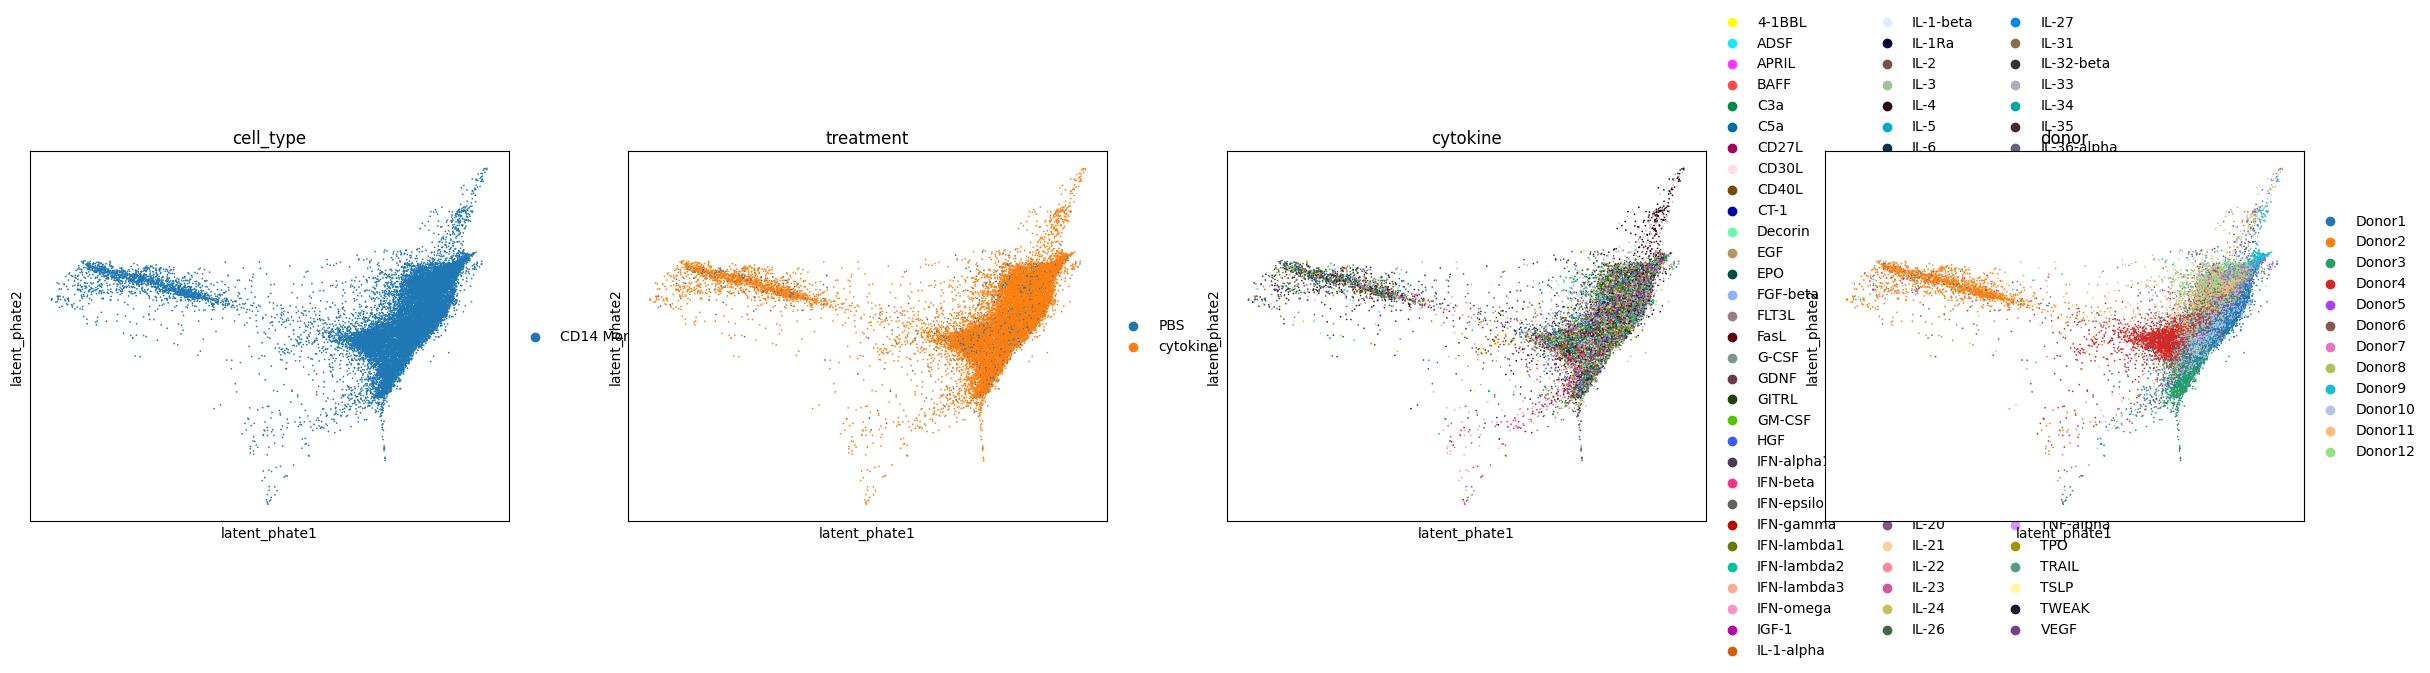

In [41]:
sc.pl.embedding(adata_sample, basis='latent_phate', color=['cell_type', 'treatment', 'cytokine', 'donor'])

In [42]:
adata_latent = sc.AnnData(X=adata_sample.obsm['X_latent'])
adata_latent.obs = adata_sample.obs.copy() 
sc.tl.pca(adata_latent, svd_solver='arpack')

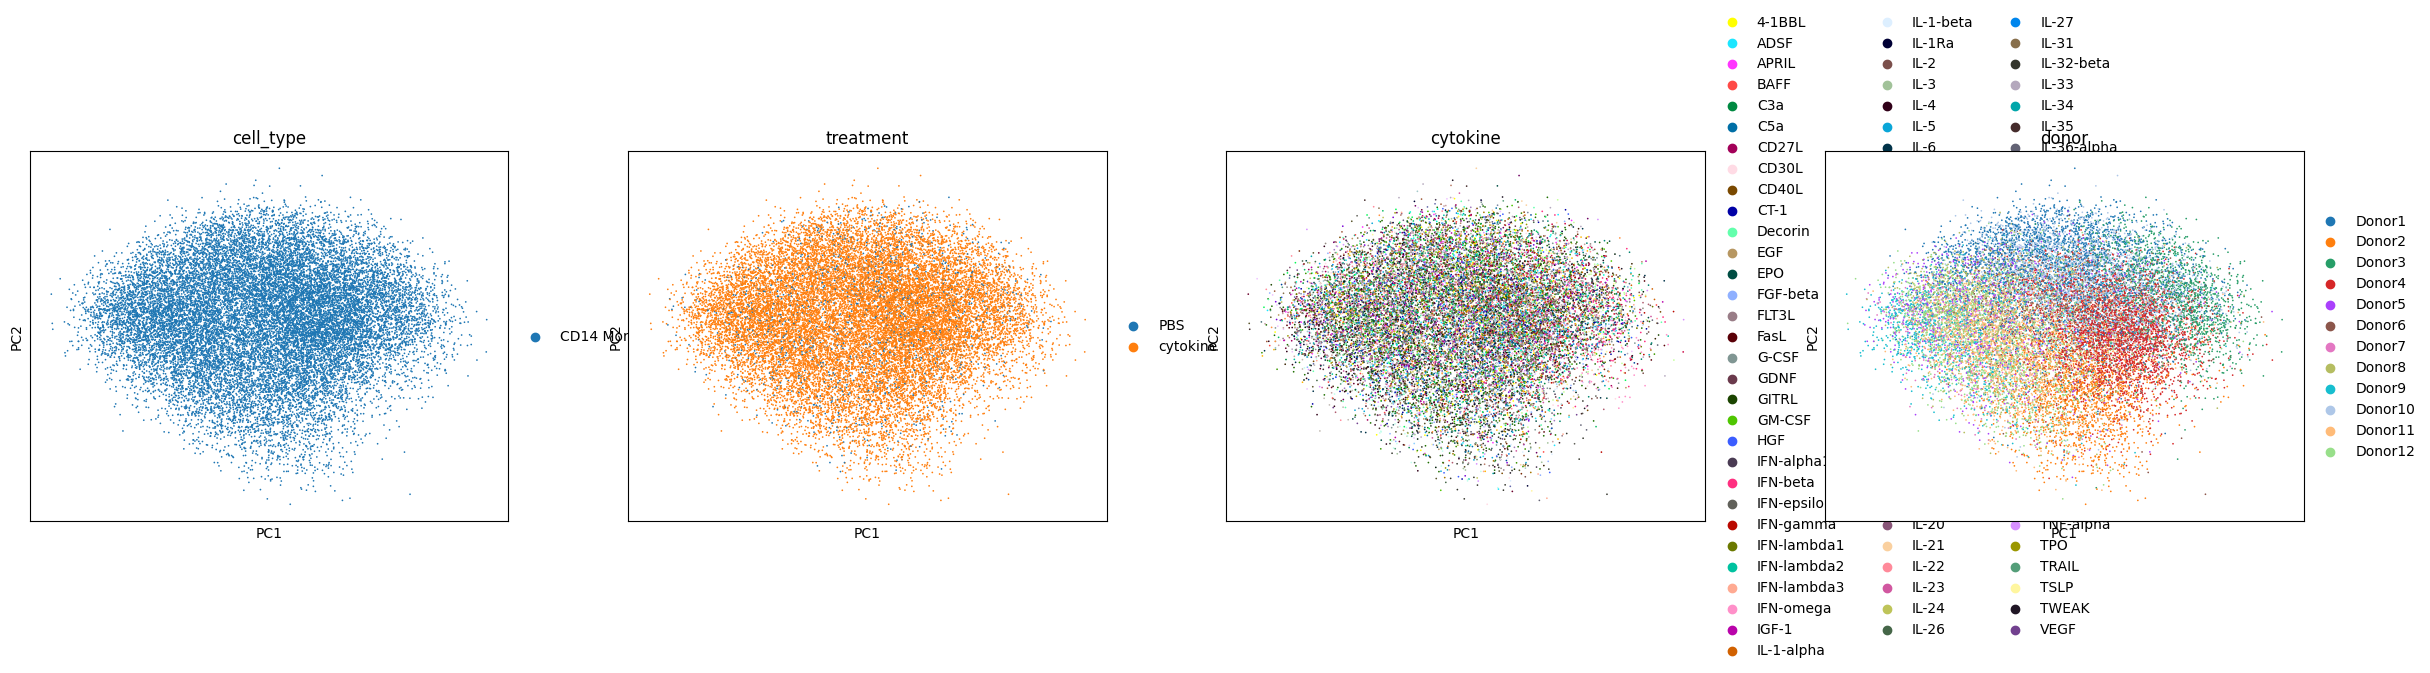

In [43]:
sc.pl.pca(
    adata_latent,
    color=['cell_type', 'treatment', 'cytokine', 'donor'],
)

In [52]:
true_phate_distances = geodesic_dataset.distance_matrix[:100, :100].ravel().cpu()
latent_space_phate_distances = torch.cdist(torch.from_numpy(latent_embeddings), torch.from_numpy(latent_embeddings))[:100, :100].ravel().cpu()

In [53]:
px.scatter(x=true_phate_distances, y=latent_space_phate_distances, height=500, width=500)

In [54]:
subset_size = 100
subset_idx = np.arange(subset_size)

true_dist_matrix = geodesic_dataset.distance_matrix[np.ix_(subset_idx, subset_idx)].cpu()
latent_dist_matrix = torch.cdist(
    torch.from_numpy(latent_embeddings[subset_idx]),
    torch.from_numpy(latent_embeddings[subset_idx])
).cpu().numpy()

tri_r, tri_c = np.triu_indices(subset_size, k=1)  # use each unordered pair once

donors = adata_sample.obs['donor'].iloc[subset_idx].to_numpy()

phate_distance_df = pd.DataFrame({
    "true_distance": true_dist_matrix[tri_r, tri_c],
    "latent_distance": latent_dist_matrix[tri_r, tri_c],
    "same_donor": donors[tri_r] == donors[tri_c],
    "source_donor": donors[tri_r],
    "target_donor": donors[tri_c]
})

In [55]:
px.scatter(
    phate_distance_df,
    x="true_distance",
    y="latent_distance",
    color="same_donor",
    color_discrete_map={True: "#2ca02c", False: "#d62728"},
    title="latent vs phate distances - same donor",
    height=500,
    width=600
).show()

In [56]:
save_path = "models/model_no_geodesic_c14_mono_all_donors_20k_dim32.pt"
torch.save(
    {
        "model_state": model.state_dict(),
        "input_dim": input_dim,
        "latent_dim": latent_dim,
        "hidden_dim": hidden_dim,
        "optimizer_state": optimizer.state_dict(),
        "history": history,
    },
    save_path,
)

In [57]:
adata_sample.layers['counts'].toarray().mean(axis=0).argmax()

np.int64(1022)

0.0055656470358371735 1.1044319868087769 -10.820240020751953


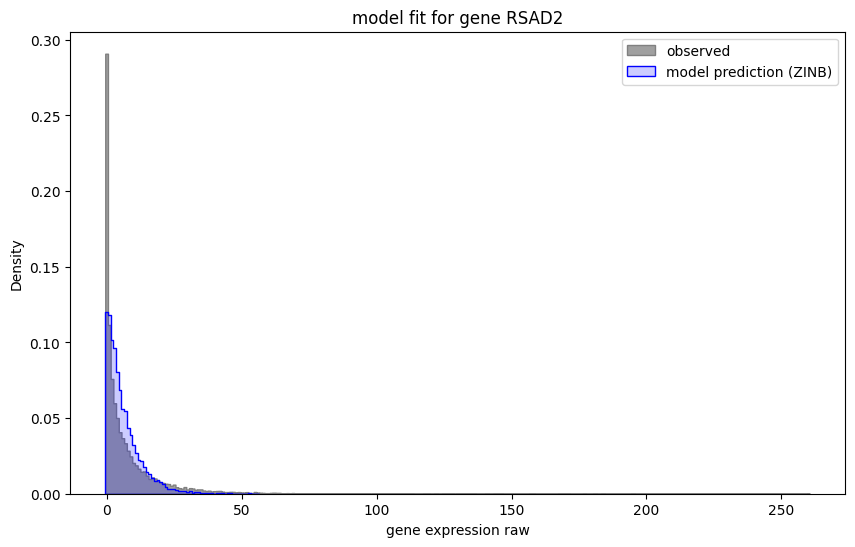

In [58]:
target_name = 'RSAD2'
gene_idx = np.where(adata_sample.var.index == target_name)[0][0]

# gene_idx = 13246

library_size = np.array(adata_sample.layers['counts'].sum(axis=1)).mean()
avg_proportion = mean_proportions[:, gene_idx].mean().item()
gene_theta = dispersion[gene_idx].item()
avg_dropout = dropout[:, gene_idx].mean().item()

print(avg_proportion, gene_theta, avg_dropout)

dist = ZeroInflatedNegativeBinomial(
    mu=torch.tensor(avg_proportion * library_size),           
    theta=torch.tensor(gene_theta),     
    zi_logits=torch.tensor(avg_dropout),
)

synthetic_counts = dist.sample((10000,)).flatten().cpu().numpy()
real_counts = adata_sample.layers['counts'][:, gene_idx].toarray().flatten()

plt.figure(figsize=(10, 6))

sns.histplot(real_counts, label='observed', fill=True, stat='density', discrete=True, element='step', color='gray')
sns.histplot(synthetic_counts, label='model prediction (ZINB)', fill=True, stat='density', discrete=True, element='step', color='blue', alpha=0.2)

plt.title(f"model fit for gene {adata_sample.var_names[gene_idx]}")
plt.xlabel("gene expression raw")
plt.legend()
# plt.xlim(0, max(real_counts.max(), synthetic_counts.max()) * 1.1)
plt.show()

In [59]:
from scvi.distributions import ZeroInflatedNegativeBinomial
import matplotlib.pyplot as plt

# gene_idx = 13246
perturbation = 'GM-CSF'
donor_id = 'Donor2'

control_mask = (adata_sample.obs['cytokine'] == 'PBS') & (adata_sample.obs['donor'] == donor_id)
treated_mask = (adata_sample.obs['cytokine'] == perturbation) & (adata_sample.obs['donor'] == donor_id)

def get_recon(mask):
    subset_data = adata_sample[mask.values]
    x = torch.from_numpy(subset_data.X.toarray().astype("float32")).to(device)
    library_size = torch.from_numpy(subset_data.layers['counts'].sum(axis=1)).to(device)

    model.eval()
    with torch.no_grad():
        z = model.z_layer(model.encoder(x))
        h = model.decoder(z)

        mean = model.decoder_mean(h)[:, gene_idx] * library_size.flatten()
        dispersion = torch.exp(model.decoder_dispersion)[gene_idx]
        dropout = model.decoder_dropout(h)[:, gene_idx]

        dist = ZeroInflatedNegativeBinomial(mu=mean, theta=dispersion, zi_logits=dropout)
        samples = dist.sample((1,)).flatten().cpu().numpy()
    
    return samples

real_control = adata_sample.layers['counts'][control_mask.values, gene_idx].toarray().flatten()
real_treatment = adata_sample.layers['counts'][treated_mask.values, gene_idx].toarray().flatten()

recon_control = get_recon(control_mask)
recon_treatment = get_recon(treated_mask)

fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x=real_control,
        xbins=dict(start=0, size=1),
        name='real control',
    )
)

fig.add_trace(
    go.Histogram(
        x=real_treatment,
        xbins=dict(start=0, size=1),
        name='real treatment',
    )
)

fig.add_trace(
    go.Histogram(
        x=recon_control,
        xbins=dict(start=0, size=1),
        name='recon control'
    )
)

fig.add_trace(
    go.Histogram(
        x=recon_treatment,
        xbins=dict(start=0, size=1),
        name='recon treatment'
    )
)